Astromatch
==========

Astromatch is a python module for statistical cross-matching of astronomical catalogues. It implements different matching methods and provides a consistent output format (as far as possible) for all of them. This allows easy comparisons between different methods.

Astromatch is design as a coherent framework, well integrated with other tools in the Astropy package. When using Astromatch, you should keep in mind that it is more a library that allows you to write your own python scripts for cross-matching astronomical catalogues, than a simple stand-alone software.

Catalogue objects
---------------------------

Astromatch provides a useful data structure for defining an astronomical catalogue. The basic information needed for building a ``Catalogue`` object is the position of the sources, the positional errors, their ID labels and the area covered by the catalogue. Having a reasonable estimation of the catalogue area is crucial when using statistical cross-matching methods.

As an example, lets build an Astromatch Catalogue for X-ray sources in a sky region of 1 deg radius within the XXL-North survey. 

Lets firs retrieve the data we need from the Vizier database (we will use only the data from the 0.5-2 keV band):

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table


region_center = SkyCoord(ra=35.30109, dec=-4.45962, unit='deg')
search_radius = 1*u.deg

try:
    xcat_table = Table.read('xxl_1deg.fits')

except FileNotFoundError:
    from astroquery.vizier import Vizier

    v = Vizier(
        columns=['Xseq', 'RABdeg', 'DEBdeg', 'e_Bpos'],
        column_filters={'e_Bpos':'>0', 'Bp1': '==1'},
        row_limit=-1,
    )
    result = v.query_region(region_center, radius=search_radius, catalog='IX/52/3xlss')
    xcat_table = result[0]
    xcat_table.meta['description'] = ''
    xcat_table.write('xxl_1deg.fits', format='fits', overwrite=True)

We use the output of the Vizier query for building the corresponding Astromatch catalogue:

In [3]:
import numpy as np
from astromatch import Catalogue

xcat = Catalogue(
    xcat_table,
    name='xxl',
    id_col='Xseq',
    coord_cols=['RABdeg', 'DEBdeg'],
    poserr_cols=['e_Bpos'],
    poserr_type='circle',
    area=np.pi * search_radius**2,
)
xcat

SRCID_xxl    RA      DEC    e_Bpos
            deg      deg    arcsec
--------- -------- -------- ------
   225328 34.31101  -4.6003    0.8
   225285  34.3179 -4.50244    1.8
   214851  34.3196 -4.28354    1.8
   225342  34.3372 -4.63358    1.7
   215403 34.33934 -4.18971    1.8
   225338 34.34105 -4.61523    1.7
   214878 34.34372 -4.37113    0.8
   225341 34.34508 -4.62884    1.7
   225368 34.34713 -4.69338    1.3
   214858 34.34764 -4.31242    1.0
      ...      ...      ...    ...
   217268 36.26386 -4.19097    1.8
   217929 36.26876 -4.61878    1.5
   217307 36.27068   -4.308    1.9
   217889 36.27654  -4.4801    0.8
   217928 36.27669  -4.6049    1.0
   217919 36.28076 -4.56787    1.3
   217296 36.28341 -4.27467    1.5
   217927 36.29433 -4.59714    1.0
   217894   36.294 -4.49086    1.7
   217882 36.29906 -4.46167    1.7
Length = 1238 rows

Astropy units for coordinates and positional errors of the Catalogue are always defined. If the initial data have no units defined for those columns, Astromatch asigns by default degrees to the coordinates and arcsec for the positional errors. By default it assumes that coordinates are in the ICRS reference frame (equatorial system). Other frames can be used by setting the `frame` parameter while defining the Catalogue (see the Astropy SkyCoord documentation for all suported frames). Internally all coordinates frames are transformed into ICRS.

Instead of passing an Astropy Table for the definition of the catalogue, a path to a file (in a tabular format suported by Astropy) can be used:

In [4]:
xcat = Catalogue(
    'xxl_1deg.fits',
    name='xxl',
    id_col='Xseq',
    coord_cols=['RABdeg', 'DEBdeg'],
    poserr_cols=['e_Bpos'],
    poserr_type='circle',
    area=np.pi * search_radius**2,
)

The area of the Catalogue can be set using a MOC object (or the path to a file containing the MOC). The ``mocpy`` package have multiple tools for defining MOCs. For example, for the circular sky region we queried, we can define the following MOC:

In [5]:
from mocpy import MOC

moc_xxl = MOC.from_elliptical_cone(
    lon=region_center.ra,
    lat=region_center.dec,
    a=search_radius,
    b=search_radius,
    pa=0*u.deg,
    max_depth=14
)

Now we can use the MOC for the Catalogue definition:

In [6]:
xcat = Catalogue(
    'xxl_1deg.fits',
    name='xxl',
    id_col='Xseq',
    coord_cols=['RABdeg', 'DEBdeg'],
    poserr_cols=['e_Bpos'],
    poserr_type='circle',
    area=moc_xxl,
)
xcat.area

<Quantity 3.15950474 deg2>

We strongly recomend using MOCs for defining the areas covered by Catalogues. When cross-matching catalogues with partial common coverage, Astromatch can use the corresponding MOCs to cross-match only the sources in the common area.

Catalogues can be access by index and sliced as Python lists:

In [7]:
xcat[10]
xcat[10:20]
xcat[[10, 20, 30]]

SRCID_xxl    RA      DEC    e_Bpos
            deg      deg    arcsec
--------- -------- -------- ------
   225336 34.35209 -4.61097    2.0
   225330 34.38474  -4.5968    2.0
   225412 34.40112 -4.79919    1.9

It is also possible to select sources by their ids:

In [8]:
list_of_ids = ['225336', '225330', '225412']
xcat_new = xcat.select_by_id(list_of_ids)
xcat_new

SRCID_xxl    RA      DEC    e_Bpos
            deg      deg    arcsec
--------- -------- -------- ------
   225336 34.35209 -4.61097    2.0
   225330 34.38474  -4.5968    2.0
   225412 34.40112 -4.79919    1.9

Sources can also be removed by id from a Catalogue:

In [9]:
list_of_ids = ['225336', '225330', '225412']
xcat_new = xcat.remove_by_id(list_of_ids)
xcat_new

SRCID_xxl    RA      DEC    e_Bpos
            deg      deg    arcsec
--------- -------- -------- ------
   225328 34.31101  -4.6003    0.8
   225285  34.3179 -4.50244    1.8
   214851  34.3196 -4.28354    1.8
   225342  34.3372 -4.63358    1.7
   215403 34.33934 -4.18971    1.8
   225338 34.34105 -4.61523    1.7
   214878 34.34372 -4.37113    0.8
   225341 34.34508 -4.62884    1.7
   225368 34.34713 -4.69338    1.3
   214858 34.34764 -4.31242    1.0
      ...      ...      ...    ...
   217268 36.26386 -4.19097    1.8
   217929 36.26876 -4.61878    1.5
   217307 36.27068   -4.308    1.9
   217889 36.27654  -4.4801    0.8
   217928 36.27669  -4.6049    1.0
   217919 36.28076 -4.56787    1.3
   217296 36.28341 -4.27467    1.5
   217927 36.29433 -4.59714    1.0
   217894   36.294 -4.49086    1.7
   217882 36.29906 -4.46167    1.7
Length = 1235 rows

Two Catalogue objects can be joined in a single Catalogue:

In [10]:
cat1 = xcat[1:4]
cat2 = xcat[10:14]

cat1.join(cat2)

SRCID_xxl    RA      DEC    e_Bpos
            deg      deg    arcsec
--------- -------- -------- ------
   214851  34.3196 -4.28354    1.8
   214857 34.36319 -4.31538    1.5
   225285  34.3179 -4.50244    1.8
   225289 34.35908 -4.51431    1.8
   225336 34.35209 -4.61097    2.0
   225342  34.3372 -4.63358    1.7
   226800 34.35493  -4.1663    1.6

The different atributes of the Catalogue can be access independently:

In [11]:
# IDs
xcat.ids

# Area
xcat.area

# Coordinates
xcat.coords

# Positional errors
xcat.poserr

<SkyCoordErr (circle): (e_Bpos) in arcsec
    [(0.8,) (1.8,) (1.8,) ... (1. ,) (1.7,) (1.7,)]>

The positional errors are defined as SkyCoordErr objects. This class allows to manipulate the errors in several ways. For example, adding a systematic error:

In [12]:
# Save the original positional errors
old_poserr = xcat.poserr[:]

# Add systematic error to the catalogue
xcat.poserr.add_syserr(1.5*u.arcsec)
print(xcat)

# Recover original errors
xcat.poserr = old_poserr

SRCID_xxl    RA      DEC      e_Bpos 
            deg      deg      arcsec 
--------- -------- -------- ---------
   225328 34.31101  -4.6003       1.7
   225285  34.3179 -4.50244 2.3430748
   214851  34.3196 -4.28354 2.3430748
   225342  34.3372 -4.63358 2.2671568
   215403 34.33934 -4.18971 2.3430748
   225338 34.34105 -4.61523 2.2671568
   214878 34.34372 -4.37113       1.7
   225341 34.34508 -4.62884 2.2671568
   225368 34.34713 -4.69338 1.9849433
   214858 34.34764 -4.31242 1.8027756
      ...      ...      ...       ...
   217268 36.26386 -4.19097 2.3430748
   217929 36.26876 -4.61878 2.1213202
   217307 36.27068   -4.308 2.4207437
   217889 36.27654  -4.4801       1.7
   217928 36.27669  -4.6049 1.8027756
   217919 36.28076 -4.56787 1.9849433
   217296 36.28341 -4.27467 2.1213202
   217927 36.29433 -4.59714 1.8027756
   217894   36.294 -4.49086 2.2671568
   217882 36.29906 -4.46167 2.2671568
Length = 1238 rows


Cross-matching: Match
----------------------------------

The ``Match`` class is the basic tool for cross-matching Catalogues. It can use several matching algorithms, and implements different methods to calculate the statistical properties (completeness, error rate, etc) of the results.

As an example, we will cross-match the catalogue of X-ray sources we defined above with a catalogue of optical sources from the SDSS. First, we download the data we need, if it is not already available. We will use the optical magnitudes during the cross-match, so we need to download that too:

In [13]:
sdss_mags = ['umag', 'gmag', 'rmag', 'imag', 'zmag']

try:
    ocat_table = Table.read('sdss_1deg.fits')

except FileNotFoundError:
    from astroquery.vizier import Vizier

    sdss_cols = ['objID', 'RA_ICRS', 'DE_ICRS', 'e_RA_ICRS', 'e_DE_ICRS'] + sdss_mags

    v = Vizier(
        columns=sdss_cols,
        column_filters={'mode': '=1', 'q_mode': '=+', 'e_RA_ICRS': '>0', 'e_DE_ICRS': '>0'},
        row_limit=-1,
    )
    result = v.query_region(region_center, radius=1*u.deg, catalog='V/147/sdss12')
    ocat_table = result[0]
    ocat_table.meta['description'] = ''
    ocat_table.write('sdss_1deg.fits', format='fits', overwrite=True)

Now we can define a new Catalogue. Since the optical sources are from the exact same sky region as the X-ray sources, we can use the MOC we defined above to set the area of the Catalogue. Note also that here we are using a different type for the positional errors:

In [14]:
ocat = Catalogue(
    ocat_table,
    name='sdss',
    id_col='objID',
    coord_cols=['RA_ICRS', 'DE_ICRS'],
    poserr_cols=['e_RA_ICRS', 'e_DE_ICRS'],
    poserr_type='rcd_dec_ellipse',
    area=moc_xxl,
    mag_cols=sdss_mags,
)

We define a match between `xcat` and `ocat`:

In [15]:
from astromatch import Match

xm = Match(xcat, ocat)

INFO: Selecting sources in common area... [astromatch.core]
INFO: xxl catalogue: 1238 sources in common area. [astromatch.core]
INFO: sdss catalogue: 43559 sources in common area. [astromatch.core]


We calculate the cross-match using the likelihood ratio method. We use a search radius of 10 arcsec, and we assume that the statistical distribution of positional errors follows a normal distribution (by default the likelihood ratio method assumes a Rayleigh distribution):

In [16]:
match_results_lr = xm.run(method='lr', radius=10.0*u.arcsec, poserr_dist="normal")

INFO: Using LR method: [astromatch.core]


INFO: Searching for match candidates within 10.0 arcsec... [astromatch.lr]
INFO: Calculating priors... [astromatch.lr]
INFO: Estimating priors using Catalogues: xxl and sdss... [astromatch.priors]
INFO: Using columns: ['umag', 'gmag', 'rmag', 'imag', 'zmag'] [astromatch.priors]
INFO: Calculating likelihood ratios for match candidates... [astromatch.lr]
INFO: Sorting and flagging match results... [astromatch.lr]


By default all cross-matching methods included in astromatch try to estimate magnitude priors using the information provided within the catalogues.

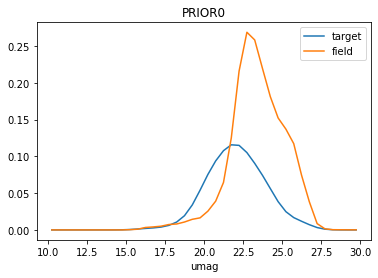

Overal identification rate for PRIOR0 (umag band): 0.536184


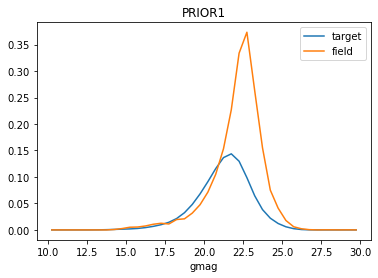

Overal identification rate for PRIOR1 (gmag band): 0.537316


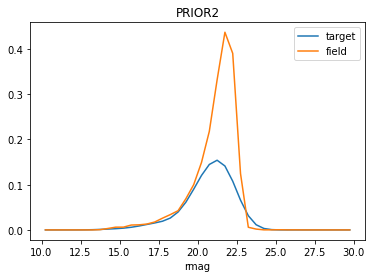

Overal identification rate for PRIOR2 (rmag band): 0.535093


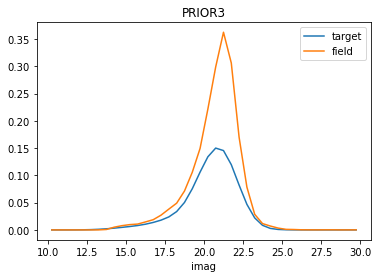

Overal identification rate for PRIOR3 (imag band): 0.535472


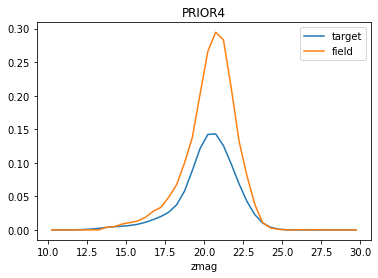

Overal identification rate for PRIOR4 (zmag band): 0.535579


In [17]:
for p in xm.priors.magnames:
    xm.priors.plot(p)
    print(
        "Overal identification rate for {} ({} band): {:02f}".format(
            p, xm.priors.prior_dict[p]["name"][0], xm.priors.qcap(p)
        )
    )

Priors can be stored into files for later use:

In [18]:
prior_table = xm.priors.to_table(include_bkg_priors=True)
prior_table.write("lrpriors.fits", format="fits", overwrite=True)


Full output of the LR algorithm:

In [19]:
xm.lr

SRCID_xxl,SRCID_sdss,Separation_xxl_sdss,ncat,PEF,LR_PRIOR0,LR_PRIOR1,LR_PRIOR2,LR_PRIOR3,LR_PRIOR4,REL_PRIOR0,p_any_PRIOR0,p_i_PRIOR0,REL_PRIOR1,p_any_PRIOR1,p_i_PRIOR1,REL_PRIOR2,p_any_PRIOR2,p_i_PRIOR2,REL_PRIOR3,p_any_PRIOR3,p_i_PRIOR3,REL_PRIOR4,p_any_PRIOR4,p_i_PRIOR4,LR_BEST,REL_BEST,LR_BEST_MAG,prob_has_match,prob_this_match
,,arcsec,,1 / arcsec2,,,,,,,,,,,,,,,,,,,,,,,,,
str11,str21,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,float64
208384,1237679323935408452,3.509611010899394,2,0.004619385231110828,0.6412782277149981,1.064703243952401,1.2116442020347868,1.764048533594662,1.9344133242860126,0.5802927597971037,0.5802927597971037,1.0,0.6970747675699615,0.6970747675699615,1.0,0.7227004777748501,0.7227004777748501,1.0,0.7915582981776547,0.7915582981776547,1.0,0.806397053283155,0.806397053283155,1.0,1.9344133242860126,0.806397053283155,PRIOR4,0.806397053283155,1.0
208385,1237679323935408430,8.155210562432602,2,6.272762025102117e-16,1.173831005591134e-13,1.445783311529885e-13,1.9292274221114706e-13,2.9416330128694134e-13,3.1347220817788203e-13,1.235646373715037e-15,0.9951175879750264,1.2417089082200474e-15,1.6262824444534922e-15,0.994795518958133,1.6347906815631081e-15,3.9771146628301675e-15,0.99041591683236,4.015600512106211e-15,5.733331443513781e-15,0.9909462021821781,5.785714129473752e-15,6.314334188234744e-15,0.9906450638824392,6.373962197407236e-15,1.173831005591134e-13,1.235646373715037e-15,PRIOR0,0.9951175879750264,1.2417089082200474e-15
208385,1237679323935408431,0.8754558926456739,2,0.10841811184318062,94.53350918211099,88.43843597885592,48.043310428501634,50.843041026361355,49.18011715281362,0.9951175872766098,0.9951175879750264,0.9999999992981567,0.9947955181136043,0.994795518958133,0.999999999151053,0.9904159155428753,0.99041591683236,0.9999999986980372,0.9909462007157559,0.9909462021821781,0.9999999985201798,0.9906450620438513,0.9906450638824392,0.9999999981440497,94.53350918211099,0.9951175872766098,PRIOR0,0.9951175879750264,0.9999999992981567
208385,1237679323935408432,6.406524871937158,2,2.0337872155800483e-10,6.634758679465154e-08,7.507939407586007e-08,6.25504052494784e-08,7.523826220275946e-08,9.1275536867152e-08,6.984153139341309e-10,0.9951175879750264,7.018419957337328e-10,8.445269740772829e-10,0.994795518958133,8.489452937642612e-10,1.2894806026103423e-09,0.99041591683236,1.3019586829081652e-09,1.4664164175314302e-09,0.9909462021821781,1.4798143575324388e-09,1.838581628463497e-09,0.9906450638824392,1.8559438647560688e-09,6.634758679465154e-08,6.984153139341309e-10,PRIOR0,0.9951175879750264,7.018419957337328e-10
208388,1237679323935408818,9.863831019638171,2,3.408446236748559e-11,4.626802709290628e-09,7.855988586236354e-09,8.940202892995305e-09,1.590212932739452e-08,1.4273206250636562e-08,9.97551147387905e-09,9.97551147387905e-09,1.0,1.6979158870847494e-08,1.6979158870847494e-08,1.0,1.9230097167702993e-08,1.9230097167702993e-08,1.0,3.4232848061618786e-08,3.4232848061618786e-08,1.0,3.073330189839391e-08,3.073330189839391e-08,1.0,1.590212932739452e-08,3.4232848061618786e-08,PRIOR3,3.4232848061618786e-08,1.0
208389,1237679323935408611,3.8288362182024844,2,0.0001085887897345933,0.05517623985631659,0.06324928072306239,0.048118942910759605,0.050923081002043076,0.05426567685056176,0.10631417338693441,0.10631417338936677,0.999999999977121,0.12026099050576511,0.12026099050838242,0.9999999999782364,0.09379440434183274,0.09379440434406815,0.999999999976167,0.09879316829558117,0.09879316829834371,0.9999999999720371,0.10462120615842385,0.10462120616165022,0.9999999999691614,0.06324928072306239,0.12026099050576511,PRIOR1,0.12026099050838242,0.9999999999782364
208389,1237679323935408620,7.964810803039035,2,3.728805296268797e-15,1.2623785022046937e-12,1.376527692405982e-12,1.1468175263924729e-12,1.4239543112019717e-12,1.6734725377499469e-12,2.43236449806

All matches within the search radius (10 arcsec):

In [20]:
all_matches = xm.get_matchs()
all_matches

SRCID_xxl,SRCID_sdss,Separation_xxl_sdss,ncat,LR_BEST,REL_BEST,LR_BEST_MAG,match_flag,prob_has_match,prob_this_match
,,arcsec,,,,,,,
str11,str21,float64,int64,float64,float64,bytes6,int64,float64,float64
225328,1237679322861011512,1.3714570888758941,2,46.68379428075735,0.9901862406293075,PRIOR1,1,0.9901862406293075,1.0
214851,1237679323397882147,1.3144638565450806,2,56.412686099022395,0.9918452073221287,PRIOR0,1,0.9918452073221287,1.0
225342,1237679322861011562,7.170840526164801,2,0.0033329625513313,0.007125453417599189,PRIOR4,1,0.007125453417599189,1.0
215403,1237679323397948127,2.427267359409059,2,9.97973834624464,0.9554885031788347,PRIOR2,1,0.9554885031788347,1.0
214878,1237679254134587627,1.9889052193363361,2,9.876985654339315,0.9551469900208761,PRIOR0,1,0.9551469900208761,1.0
225341,1237679322861076661,1.5086594463281928,2,55.668857495643444,0.9917371460511851,PRIOR0,1,0.9917371460511851,1.0
214858,1237679323397948131,5.848338687360705,2,2.9874786810323946e-06,6.432646931207171e-06,PRIOR4,1,6.433085669821996e-06,0.9999317996623481
214858,1237679323397947748,7.292553467416126,2,2.0376095133996957e-10,4.3873861482551484e-10,PRIOR4,0,6.433085669821996e-06,6.820033765190862e-05


List of most likely counterparts:

In [21]:
primary_matches = xm.get_matchs(match_type='primary')
primary_matches

SRCID_xxl,SRCID_sdss,Separation_xxl_sdss,ncat,LR_BEST,REL_BEST,LR_BEST_MAG,match_flag,prob_has_match,prob_this_match
,,arcsec,,,,,,,
str11,str21,float64,int64,float64,float64,bytes6,int64,float64,float64
225328,1237679322861011512,1.3714570888758941,2,46.68379428075735,0.9901862406293075,PRIOR1,1,0.9901862406293075,1.0
214851,1237679323397882147,1.3144638565450806,2,56.412686099022395,0.9918452073221287,PRIOR0,1,0.9918452073221287,1.0
225342,1237679322861011562,7.170840526164801,2,0.0033329625513313,0.007125453417599189,PRIOR4,1,0.007125453417599189,1.0
215403,1237679323397948127,2.427267359409059,2,9.97973834624464,0.9554885031788347,PRIOR2,1,0.9554885031788347,1.0
214878,1237679254134587627,1.9889052193363361,2,9.876985654339315,0.9551469900208761,PRIOR0,1,0.9551469900208761,1.0
225341,1237679322861076661,1.5086594463281928,2,55.668857495643444,0.9917371460511851,PRIOR0,1,0.9917371460511851,1.0
214858,1237679323397948131,5.848338687360705,2,2.9874786810323946e-06,6.432646931207171e-06,PRIOR4,1,6.433085669821996e-06,0.9999317996623481
226800,1237679323397947782,5.821647381203046,2,0.07638224997903424,0.13492525038451214,PRIOR0,1,0.18069314243359705,0.7467093026737074


List of most likely counterparts, including X-ray sources with no counterparts:

In [22]:
primary_matches = xm.get_matchs(match_type='primary_all')
primary_matches

SRCID_xxl,SRCID_sdss,Separation_xxl_sdss,ncat,LR_BEST,REL_BEST,LR_BEST_MAG,match_flag,prob_has_match,prob_this_match
,,arcsec,,,,,,,
str11,str21,float64,int64,float64,float64,bytes6,int64,float64,float64
225328,1237679322861011512,1.3714570888758941,2,46.68379428075735,0.9901862406293075,PRIOR1,1,0.9901862406293075,1.0
225285,--,--,1,--,--,0.0,1,0.0,0.0
214851,1237679323397882147,1.3144638565450806,2,56.412686099022395,0.9918452073221287,PRIOR0,1,0.9918452073221287,1.0
225342,1237679322861011562,7.170840526164801,2,0.0033329625513313,0.007125453417599189,PRIOR4,1,0.007125453417599189,1.0
215403,1237679323397948127,2.427267359409059,2,9.97973834624464,0.9554885031788347,PRIOR2,1,0.9554885031788347,1.0
225338,--,--,1,--,--,0.0,1,0.0,0.0
214878,1237679254134587627,1.9889052193363361,2,9.876985654339315,0.9551469900208761,PRIOR0,1,0.9551469900208761,1.0
225341,1237679322861076661,1.5086594463281928,2,55.668857495643444,0.9917371460511851,PRIOR0,1,0.9917371460511851,1.0


Set as best matches only counterparts with LR above a given threshold:

In [23]:
xm.set_best_matchs(cutoff=0.5)

best_matches = xm.get_matchs(match_type='best')
best_matches

SRCID_xxl,SRCID_sdss,Separation_xxl_sdss,ncat,LR_BEST,REL_BEST,LR_BEST_MAG,match_flag,prob_has_match,prob_this_match,best_match_flag
,,arcsec,,,,,,,,
str11,str21,float64,int64,float64,float64,bytes6,int64,float64,float64,int64
225328,1237679322861011512,1.3714570888758941,2,46.68379428075735,0.9901862406293075,PRIOR1,1,0.9901862406293075,1.0,1
214851,1237679323397882147,1.3144638565450806,2,56.412686099022395,0.9918452073221287,PRIOR0,1,0.9918452073221287,1.0,1
215403,1237679323397948127,2.427267359409059,2,9.97973834624464,0.9554885031788347,PRIOR2,1,0.9554885031788347,1.0,1
214878,1237679254134587627,1.9889052193363361,2,9.876985654339315,0.9551469900208761,PRIOR0,1,0.9551469900208761,1.0,1
225341,1237679322861076661,1.5086594463281928,2,55.668857495643444,0.9917371460511851,PRIOR0,1,0.9917371460511851,1.0,1
214857,1237679323397947789,1.7711934173395705,2,20.18104102237253,0.977499847596325,PRIOR3,1,0.9774998524097869,0.9999999950757416,1
225416,1237679253597716770,2.0121705162664454,2,17.15217184562247,0.9737332968336132,PRIOR1,1,0.9737332968336132,1.0,1
225370,1237679322861076786,4.746065774034002,2,1.0744255555312368,0.6691300326843204,PRIOR4,1,0.7107678944049352,0.941418482674327,1


If no LR threshold is given, the method will try to find the optimum threshold (maximizing the completeness while minimizing the error rate):

In [24]:
xm.set_best_matchs()

best_matches = xm.get_matchs(match_type='best')
best_matches

Optimal threshold is 0.30000000000000004:
Selects ~55% of matches with a false detection rate of < 6%


SRCID_xxl,SRCID_sdss,Separation_xxl_sdss,ncat,LR_BEST,REL_BEST,LR_BEST_MAG,match_flag,prob_has_match,prob_this_match,best_match_flag
,,arcsec,,,,,,,,
str11,str21,float64,int64,float64,float64,bytes6,int64,float64,float64,int64
225328,1237679322861011512,1.3714570888758941,2,46.68379428075735,0.9901862406293075,PRIOR1,1,0.9901862406293075,1.0,1
214851,1237679323397882147,1.3144638565450806,2,56.412686099022395,0.9918452073221287,PRIOR0,1,0.9918452073221287,1.0,1
215403,1237679323397948127,2.427267359409059,2,9.97973834624464,0.9554885031788347,PRIOR2,1,0.9554885031788347,1.0,1
214878,1237679254134587627,1.9889052193363361,2,9.876985654339315,0.9551469900208761,PRIOR0,1,0.9551469900208761,1.0,1
225341,1237679322861076661,1.5086594463281928,2,55.668857495643444,0.9917371460511851,PRIOR0,1,0.9917371460511851,1.0,1
214857,1237679323397947789,1.7711934173395705,2,20.18104102237253,0.977499847596325,PRIOR3,1,0.9774998524097869,0.9999999950757416,1
225416,1237679253597716770,2.0121705162664454,2,17.15217184562247,0.9737332968336132,PRIOR1,1,0.9737332968336132,1.0,1
225370,1237679322861076786,4.746065774034002,2,1.0744255555312368,0.6691300326843204,PRIOR4,1,0.7107678944049352,0.941418482674327,1


DRA, DDEC offsets between matches:

In [25]:
from matplotlib import pyplot as plt
from scipy.stats import norm

dra, ddec = xm.offset('xxl', 'sdss', match_type='best')

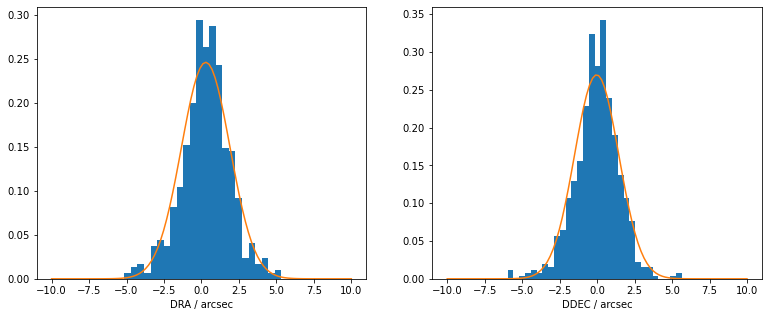

In [26]:
x = np.linspace(-10, 10, num=100)

fig = plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.hist(dra.value, bins='auto', density=True)
plt.plot(x, norm.pdf(x, np.mean(dra), np.std(dra)))
plt.xlabel('DRA / arcsec')

plt.subplot(122)
plt.hist(ddec.value, bins='auto', density=True)
plt.plot(x, norm.pdf(x, np.mean(ddec), np.std(ddec)))
plt.xlabel('DDEC / arcsec')

plt.show()

How to obtain the information in the optical and X-ray catalogues for the primary counterparts:

In [27]:
ocat_best = ocat.select_by_id(best_matches['SRCID_sdss'])
ocat_best

     SRCID_sdss         RA       DEC    e_RA_ICRS ...  rmag   imag   zmag 
                       deg       deg      arcsec  ...  mag    mag    mag  
------------------- --------- --------- --------- ... ------ ------ ------
1237679322861011512 34.311354 -4.600466     0.024 ... 20.062 19.671 19.333
1237679323397882147 34.319672 -4.283898     0.025 ... 20.590 20.662 20.694
1237679323397948127 34.340016 -4.189702     0.088 ... 22.611 22.353 21.180
1237679254134587627 34.344256  -4.37099     0.022 ... 20.801 20.766 20.311
1237679322861076661 34.345445 -4.628632     0.047 ... 21.579 21.498 21.188
1237679323397947789 34.363663  -4.31552     0.082 ... 22.112 22.576 21.722
1237679253597716770 34.362917 -4.810162     0.018 ... 20.557 19.961 19.497
1237679322861076786 34.367421 -4.700677     0.089 ... 21.764 21.845 21.954
1237679254134587794 34.375441 -4.519295     0.071 ... 22.544 22.683 22.686
1237679323397947552 34.378941 -4.306573     0.009 ... 19.443 19.272 19.039
                ...      

In [28]:
xcat_best = xcat.select_by_id(best_matches['SRCID_xxl'])
xcat_best

SRCID_xxl    RA      DEC    e_Bpos
            deg      deg    arcsec
--------- -------- -------- ------
   225328 34.31101  -4.6003    0.8
   214851  34.3196 -4.28354    1.8
   215403 34.33934 -4.18971    1.8
   214878 34.34372 -4.37113    0.8
   225341 34.34508 -4.62884    1.7
   214857 34.36319 -4.31538    1.5
   225416 34.36344 -4.80996    1.0
   225370 34.36855 -4.69999    2.0
   214924   34.375 -4.51969    1.8
   214856 34.37853 -4.30686    1.0
      ...      ...      ...    ...
   218678 36.22601 -4.72016    1.5
   217238 36.22823 -4.10764    1.5
   217909 36.23192 -4.53333    1.5
   217303 36.23278 -4.29119    1.5
   217313 36.23379 -4.32928    1.6
   218676 36.24653 -4.69802    1.5
   217294 36.25385  -4.2204    1.8
   217307 36.27068   -4.308    1.9
   217919 36.28076 -4.56787    1.3
   217882 36.29906 -4.46167    1.7
Length = 679 rows

Join X-ray and optical information of the best matches in a single Astropy Table:

In [29]:
from astropy.table import hstack

best_all = hstack(
    [xcat_best.save(), ocat_best.save()],  # Catalogues can be converted into Tables using the `save` method
    table_names=[xcat_best.name, ocat_best.name],
    join_type='exact')
best_all

SRCID_xxl,RA_xxl,DEC_xxl,e_Bpos,SRCID_sdss,RA_sdss,DEC_sdss,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag
,deg,deg,arcsec,,deg,deg,arcsec,arcsec,mag,mag,mag,mag,mag
str11,float64,float64,float32,str21,float64,float64,float32,float32,float32,float32,float32,float32,float32
225328,34.31101,-4.6003,0.8,1237679322861011512,34.311354,-4.600466,0.024,0.021,23.089,21.392,20.062,19.671,19.333
214851,34.3196,-4.28354,1.8,1237679323397882147,34.319672,-4.283898,0.025,0.022,21.144,20.703,20.590,20.662,20.694
215403,34.33934,-4.18971,1.8,1237679323397948127,34.340016,-4.189702,0.088,0.115,23.631,23.822,22.611,22.353,21.180
214878,34.34372,-4.37113,0.8,1237679254134587627,34.344256,-4.37099,0.022,0.021,21.645,21.046,20.801,20.766,20.311
225341,34.34508,-4.62884,1.7,1237679322861076661,34.345445,-4.628632,0.047,0.058,21.358,21.705,21.579,21.498,21.188
214857,34.36319,-4.31538,1.5,1237679323397947789,34.363663,-4.31552,0.082,0.096,23.996,22.407,22.112,22.576,21.722
225416,34.36344,-4.80996,1.0,1237679253597716770,34.362917,-4.810162,0.018,0.019,23.055,21.299,20.557,19.961,19.497
225370,34.36855,-4.69999,2.0,1237679322861076786,34.367421,-4.700677,0.089,0.125,23.424,22.809,21.764,21.845,21.954


There are differents methods to characterize the statistical properties of the cross-match.

Using the probabilities estimated by the LR algorithm:

In [30]:
lr_stats = xm.stats(ncutoff=501, maxcutoff=10.0)

By cross-matching with a randomized catalogue of X-ray sources:

In [31]:
lr_stats_rnd = xm.stats(match_rnd=True, ncutoff=501, maxcutoff=10.0, poserr_dist="normal")


INFO: Randomizing primary catalogue... [astromatch.lr]
INFO: Cross-matching with randomized catalogue... [astromatch.lr]


By using the randomization method described in Broos et al. 2006:

In [32]:
lr_stats_broos = xm.stats(use_broos=True, ntest=1, ncutoff=501, maxcutoff=10.0, poserr_dist="normal")

INFO: Randomizing primary catalogue... [astromatch.lr]
INFO: Cross-matching with randomized catalogue... [astromatch.lr]


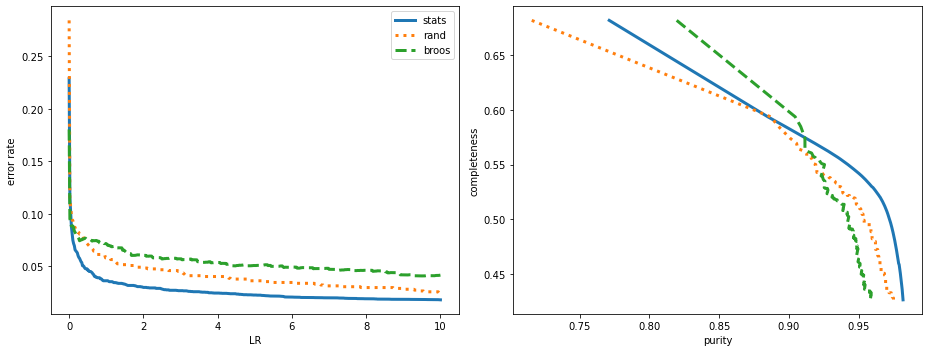

In [33]:
fig = plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(lr_stats['cutoff'], lr_stats['error_rate'], lw=3, label="stats")
plt.plot(lr_stats_rnd['cutoff'], lr_stats_rnd['error_rate'], lw=3, ls=':', label="rand")
plt.plot(lr_stats_broos['cutoff'], lr_stats_broos['error_rate'], lw=3, ls='--', label="broos")
plt.legend()

plt.xlabel('LR')
plt.ylabel('error rate')


plt.subplot(122)
plt.plot(lr_stats['reliability'], lr_stats['completeness'], lw=3)
plt.plot(lr_stats_rnd['reliability'], lr_stats_rnd['completeness'], lw=3, ls=':')
plt.plot(lr_stats_broos['reliability'], lr_stats_broos['completeness'], lw=3, ls='--')

plt.xlabel('purity')
plt.ylabel('completeness')

plt.tight_layout()
plt.show()

We repeat the cross-matching of our two catalogues using NWAY:

In [34]:
match_nway_nomags = xm.run(method='nway', radius=10.0*u.arcsec, prior_completeness=0.55)

    adding angular separation columns
matching:   2311 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
  0%|          | 0/1238 [00:00<?, ?it/s]

INFO: Using NWAY method: [astromatch.core]


100%|██████████| 1238/1238 [00:02<00:00, 594.49it/s]

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


The match we have just performed does not take into account the optical magnitudes of the SDSS sources. If we want to use that information during the cross-matching, we set the `use_mags` parameter to `True` and astromatch automatically estimates magnitude priors from the photometric data contained in the optical catalogue:

In [35]:
match_nway_mags_default = xm.run(method='nway', radius=10.0*u.arcsec, use_mags=True, prior_completeness=0.55)

    adding angular separation columns
matching:   2311 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
  0%|          | 0/1238 [00:00<?, ?it/s]

INFO: Using NWAY method: [astromatch.core]


100%|██████████| 1238/1238 [00:02<00:00, 589.27it/s]
Incorporating bias "sdss:umag" ...
magnitude histogram of column "sdss_umag": 490 secure matches, 792 insecure matches and 42767 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_umag_fit.txt".
Incorporating bias "sdss:gmag" ...
magnitude histogram of column "sdss_gmag": 490 secure matches, 792 insecure matches and 42767 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_gmag_fit.txt".
Incorporating bias "sdss:rmag" ...
magnitude histogram of column "sdss_rmag": 490 secure matches, 792 insecure matches and 42767 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_rmag_fit.txt".
Incorporating bias "sdss:imag" ...
magnitude histogram of column "sdss_imag": 490 secure matches, 792 insecure matches and 42767 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_imag_fit.txt".
Inc

INFO: Using provided prior... [astromatch.priors]


By default NWAY uses high likelihood counterparts (matches with high posterior probability estimated using only the positional information) to calculate the magnitude priors. This is controlled by the argument `dist_post_min`, by default using a value of 0.9 (i.e. only matches with a posterior positional probability above 0.9 are used for building the magnitude priors). Alternatively, if `dist_post_min` is `None`, you can build priors using the same method implemented in the LR algorithm:

In [36]:
match_nway_mags_custom = xm.run(
    method='nway',
    radius=10.0*u.arcsec,
    prior_completeness=0.55,
    use_mags=True,
    dist_post_min=None,
# Default settings for LR magnitude priors
    mag_include_radius=10*u.arcsec,
    magmin=10.0,
    magmax=30.0,
    magbinsize=0.5,
    rndcat=True,
)

INFO: Using NWAY method: [astromatch.core]
INFO: Estimating priors using Catalogues: xxl and sdss... [astromatch.priors]


    adding angular separation columns
matching:   2311 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
  0%|          | 0/1238 [00:00<?, ?it/s]

INFO: Using columns: ['umag', 'gmag', 'rmag', 'imag', 'zmag'] [astromatch.priors]


100%|██████████| 1238/1238 [00:02<00:00, 611.58it/s]
Incorporating bias "sdss:umag" ...
magnitude histogramming: using user-supplied histogram for "sdss_umag"
Incorporating bias "sdss:gmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_gmag"
Incorporating bias "sdss:rmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_rmag"
Incorporating bias "sdss:imag" ...
magnitude histogramming: using user-supplied histogram for "sdss_imag"
Incorporating bias "sdss:zmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_zmag"

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


Or we can just use the magnitude prior we calculated during the LR match. In this case we need to define a dictionary containing the priors for each secondary catalogue that is included in the match (only the SDSS catalogue in this particular example):

In [37]:
from astromatch.priors import Prior

prior_labels = [f"PRIOR{i}" for i in range(5)]
priors = {'sdss': Prior.from_table("lrpriors.fits", prior_labels)}

match_nway_mags_custom2 = xm.run(
    method='nway', radius=10.0*u.arcsec, prior_completeness=0.55, use_mags=True, priors=priors
)

INFO: Using provided prior... [astromatch.priors]
INFO: Using NWAY method: [astromatch.core]


    adding angular separation columns
matching:   2311 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 1238/1238 [00:03<00:00, 411.17it/s]
Incorporating bias "sdss:umag" ...
magnitude histogramming: using user-supplied histogram for "sdss_umag"
Incorporating bias "sdss:gmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_gmag"
Incorporating bias "sdss:rmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_rmag"
Incorporating bias "sdss:imag" ...
magnitude histogramming: using user-supplied histogram for "sdss_imag"
Incorporating bias "sdss:zmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_zmag"

Computing final probabilities ...
    grouping by primary catalogue ID and flagging

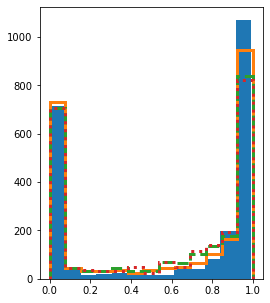

In [38]:
fig = plt.figure(figsize=(4, 5))

plt.hist(match_nway_nomags['prob_has_match'], bins='auto')
plt.hist(match_nway_mags_default['prob_has_match'], bins='auto', histtype='step', lw=3)
plt.hist(match_nway_mags_custom['prob_has_match'], bins='auto', histtype='step', lw=3, ls='--')
plt.hist(match_nway_mags_custom2['prob_has_match'], bins='auto', histtype='step', lw=3, ls=':')

plt.show()

DRA, DDEC offsets between matches for NWAY results:

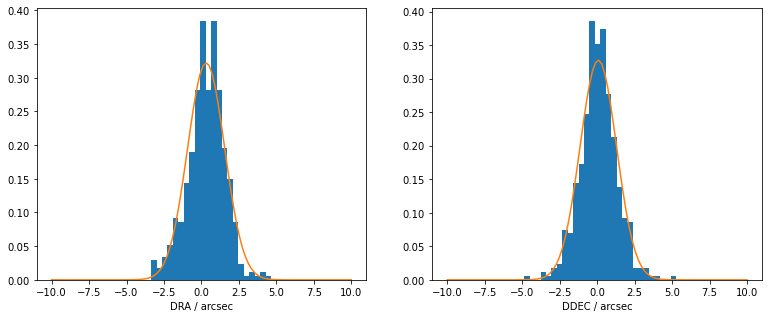

In [39]:
from matplotlib import pyplot as plt
from scipy.stats import norm

xm.set_best_matchs(cutoff=0.8)
dra, ddec = xm.offset('xxl', 'sdss', match_type='best')
x = np.linspace(-10, 10, num=100)

fig = plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.hist(dra.value, bins='auto', density=True)
plt.plot(x, norm.pdf(x, np.mean(dra), np.std(dra)))
plt.xlabel('DRA / arcsec')

plt.subplot(122)
plt.hist(ddec.value, bins='auto', density=True)
plt.plot(x, norm.pdf(x, np.mean(ddec), np.std(ddec)))
plt.xlabel('DDEC / arcsec')

plt.show()

In [40]:
nway_stats = xm.stats(ncutoff=100, maxcutoff=0.99)
nway_stats_rnd = xm.stats(match_rnd=True, ncutoff=100, maxcutoff=0.99, prior_completeness=0.55)
nway_stats_broos = xm.stats(use_broos=True, ntest=5, ncutoff=100, maxcutoff=0.99, prior_completeness=0.55)

matching: using fast flat-sky approximation for this match
100%|██████████| 44797/44797 [00:00<00:00, 89395.87it/s]
matching: collecting from 4948 buckets, creating cartesian products ...
100%|██████████| 4948/4948 [00:00<00:00, 75756.77it/s]
matching:   2381 unique matches from cartesian product. sorting ...
    adding angular separation columns
matching:   1650 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 1238/1238 [00:02<00:00, 487.81it/s]
Incorporating bias "sdss:umag" ...
magnitude histogramming: using user-supplied histogram for "sdss_umag"
Incorporating bias "sdss:gmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_gmag"
Incorporating bias "sdss:rmag" ...
magnitude histogramming: using user-supplied histogram f

matching: using fast flat-sky approximation for this match
100%|██████████| 45637/45637 [00:00<00:00, 144103.42it/s]
matching: collecting from 4952 buckets, creating cartesian products ...
100%|██████████| 4952/4952 [00:00<00:00, 117966.88it/s]
matching:   3628 unique matches from cartesian product. sorting ...
    adding angular separation columns
matching:   2885 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (44399), density gives 5.80e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 1238/1238 [00:01<00:00, 669.80it/s]
Incorporating bias "sdss:umag" ...
magnitude histogramming: using user-supplied histogram for "sdss_umag"
Incorporating bias "sdss:gmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_gmag"
Incorporating bias "sdss:rmag" ...
magnitude histogramming: using user-supplied histogram

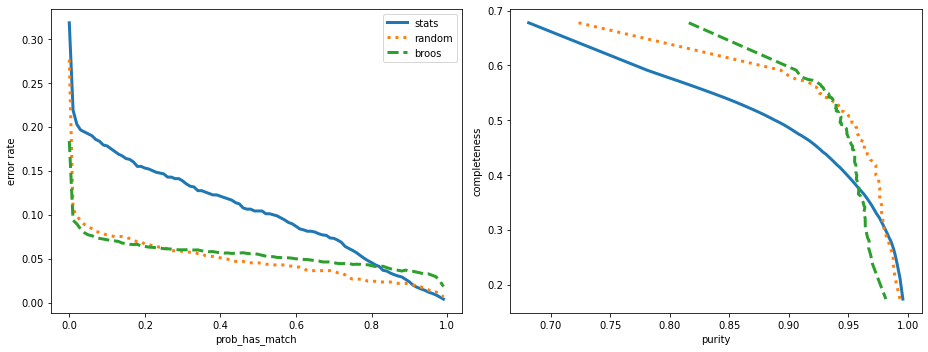

In [41]:
fig = plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(nway_stats['cutoff'], nway_stats['error_rate'], lw=3, label='stats')
plt.plot(nway_stats_rnd['cutoff'], nway_stats_rnd['error_rate'], lw=3, ls=':', label='random')
plt.plot(nway_stats_broos['cutoff'], nway_stats_broos['error_rate'], lw=3, ls='--', label='broos')
plt.legend()

plt.xlabel('prob_has_match')
plt.ylabel('error rate')


plt.subplot(122)
plt.plot(nway_stats['reliability'], nway_stats['completeness'], lw=3)
plt.plot(nway_stats_rnd['reliability'], nway_stats_rnd['completeness'], lw=3, ls=':')
plt.plot(nway_stats_broos['reliability'], nway_stats_broos['completeness'], lw=3, ls='--')

plt.xlabel('purity')
plt.ylabel('completeness')

plt.tight_layout()
plt.show()